# BOSTON HOUSING DATASET

목표:여러가지 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해 보겠습니다.
    
구성:데이터 포인트가 506개로 비교적 개수가 적음. 404개는 훈련샘플, 102개는 테스트 샘플.
    입력 데이터에 있는 각 특성은 스케일이 다름(예를들어 범죄율이 다름).
    어떤 값은 0과 1사이의 비율을, 어떤 것은 1과 100사이의 값을 가진다.

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data() #target은 주택 가격(천달러 단위)

print(train_data.shape) #404개의 훈련 샘플
print(test_data.shape) #102개의 테스트 샘플

(404, 13)
(102, 13)


In [2]:
mean = train_data.mean(axis=0) #x축의 평균(세로로 13개 값 나옴)
train_data -= mean #각 특성에서 특성들의 평균을 뺌
std = train_data.std(axis=0) #x축의 표준편차(세로로 13개 값 나옴)
train_data /= std #각 평균을 뺀 값에서 특성들의 표준편차로 나눔

test_data -= mean #테스트 데이터를 정규화할 때에도 훈련 데이터에서 계산한 값을 사용해야함
test_data /= std #머신러닝에서는 테스트 데이터를 연산한 값을 사용하면 안된다

In [3]:
from keras import models
from keras import layers
#훈련 데이터가 작을수록 overfitting이 쉽게 발생 -> 작은 모델을 사용하여 과대적합 방지
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],))) #train_data.shape[1]=>13 cf.index가 0이면 404
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1)) #softmax 없음->사용하게 되면 0에서1사이의 값이 나옴->집값 예측 불가능 
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [4]:
#k-fold cross-validation(k겹 교차검증)
import numpy as np

k=4 

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print("처리중인 폴드 #",i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples] #검증데이터 준비(k번째 분할)
    val_targets = train_targets[i*num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate( #훈련데이터 준비(다른 분할 전체)
        [train_data[:i*num_val_samples],
        train_data[(i+1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate( #concatenate=>배열 합치는 메서드
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model = build_model() #케라스 모델 구성(컴파일 포함) cf.위 cell에서 선언한 함수
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data,val_targets, verbose=0) #verbose=0으로 하면 훈련 과정이 출력되지 않음
    all_scores.append(val_mae)
print(all_scores) #검증 세트가 다르기 때문에 검증 점수가 다르다.
print(np.mean(all_scores)) #위의 평균값은 2.4 정도로 2 ~ 2.9까지 튀는 값들보다 신뢰도가 높음

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
[2.0474541187286377, 2.2157647609710693, 2.3710365295410156, 2.4661128520965576]
2.27509206533432


In [5]:
#신경망을 좀 더 오래 학습시켜본다. epochs=500만큼
num_epochs = 500
all_mae_historis = []

for i in range(k):
    print("처리중인 폴드 #",i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples] #검증데이터 준비(k번째 분할)
    val_targets = train_targets[i*num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate( #훈련데이터 준비(다른 분할 전체)
        [train_data[:i*num_val_samples],
        train_data[(i+1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate( #concatenate=>배열 합치는 메서드
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model = build_model() #케라스 모델 구성(컴파일 포함) cf.위 cell에서 선언한 함수
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data,val_targets, verbose=0) #verbose=0으로 하면 훈련 과정이 출력되지 않음
    mae_history = history.history['val_mae']
    all_mae_historis.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [6]:
#k겹 검증 점수 평균 기록
average_mae_history = [
    np.mean([x[i] for x in all_mae_historis]) for i in range(num_epochs)
]
print(average_mae_history)

[4.558439373970032, 3.463166832923889, 3.1514487862586975, 3.0525707602500916, 2.8233087062835693, 2.761350393295288, 2.6971607208251953, 2.608690083026886, 2.705323815345764, 2.6141035556793213, 2.575295627117157, 2.5639345049858093, 2.4848985075950623, 2.524558186531067, 2.7657474279403687, 2.496633231639862, 2.554107367992401, 2.6235278248786926, 2.517009139060974, 2.4170278012752533, 2.4299094676971436, 2.5104681849479675, 2.4303072690963745, 2.474245250225067, 2.417906165122986, 2.5694245100021362, 2.3475985527038574, 2.5237025022506714, 2.3726430237293243, 2.4842875599861145, 2.3097556233406067, 2.381274163722992, 2.314213067293167, 2.404289960861206, 2.398387610912323, 2.3058255910873413, 2.3434820771217346, 2.332215666770935, 2.417366087436676, 2.286779284477234, 2.4192749857902527, 2.3755195438861847, 2.4668428897857666, 2.423562914133072, 2.5327998399734497, 2.3750003576278687, 2.446927696466446, 2.444058895111084, 2.4269596934318542, 2.3193222880363464, 2.3646220266819, 2.45

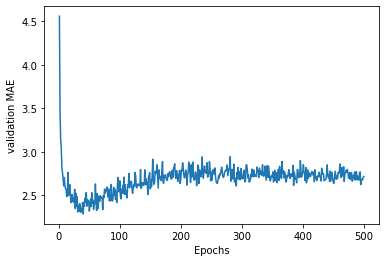

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('validation MAE')
plt.show() 

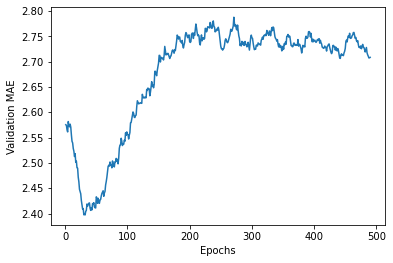

In [8]:
#위 그래프는 변동이 심하여 보기 어려움
#따라서 스케일이 많이 차이나는 첫 10개의 데이터 포인트는 제외시킨다
#부드러운 곡선을 얻기위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체한다.
# 지수 평균 이동은 데이터를 부드럽게 만드는 기법 중 하나로
#이전에 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1-factor)를 곱해 합산한 것을 가리킨다.

def smooth_curve(points, factor=0.9): 
    smoothed_points = []
    for point in points: 
        if smoothed_points: # not empty
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else:
            smoothed_points.append(point) 
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:]) 
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE') 
plt.show()

In [9]:
model = build_model() #새롭게 컴파일된 모델을 얻는다
model.fit(train_data, train_targets,#전체 데이터로 훈련
         epochs=80, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score) #2729달러 정도 차이가 남

4/4 [==============================] - 0s 998us/step - loss: 16.9640 - mae: 2.5922
2.592226028442383
